# Challenge 5: Azure AI Agents SDK - Employee Onboarding & IT Support

In this notebook, we'll explore the Azure AI Agents SDK through a series of focused examples. Unlike the previous notebook that used Semantic Kernel, this one will leverage the Azure AI Agents SDK to create AI assistants with various capabilities.

The examples all revolve around employee onboarding and IT support, but each one focuses on a different capability of the Azure AI Agents SDK. You can run them independently and modify them to experiment with different aspects of the SDK.

## What is Azure AI Agents SDK?

The Azure AI Agents SDK is a client library that allows you to build and run AI agents in Azure. It provides capabilities to:

- Create agents that can execute tasks and answer questions
- Add tools like file search, code interpreter, and custom functions
- Set up conversational threads to maintain context
- Process runs to get agent responses
- Track detailed run steps to understand agent behavior

## Azure AI Agent Service Overview

Azure AI Agent Service is a fully managed service designed to empower developers to securely build, deploy, and scale high-quality, and extensible AI agents without needing to manage the underlying compute and storage resources. What originally took hundreds of lines of code to support client-side function calling can now be done in just a few lines of code with Azure AI Agent Service.

Within Azure AI Foundry, an AI Agent acts as a "smart" microservice that can be used to:

- Answer questions (RAG)
- Perform actions
- Completely automate workflows

It achieves this by combining the power of generative AI models with tools that allow it to access and interact with real-world data sources.

## How Azure AI Agent Service Works

The basic workflow of Azure AI Agent Service consists of:

1. **Creating an agent** - Define the model, instructions, and tools the agent can use
2. **Creating a thread** - This represents a conversation context
3. **Adding messages** - Add user queries to the thread
4. **Processing a run** - This invokes the agent to work on the thread
5. **Getting responses** - Retrieve the agent's responses from the thread

Whenever a run operation is invoked, Azure AI Agent Service completes the entire tool calling lifecycle by:
1. Running the model with the provided instructions
2. Invoking the tools as the agent calls them
3. Returning the results

## Setting up the Environment

First, let's install the necessary packages and set up our environment.

In [1]:
import os
import json
import uuid
import datetime
from pathlib import Path
from dotenv import load_dotenv
from typing import List, Dict, Any, Optional, TypedDict, Annotated
from enum import Enum
from pydantic import BaseModel

import asyncio
import PyPDF2  # For reading PDF documents
import matplotlib.pyplot as plt  # For creating charts
import numpy as np
from azure.core.credentials import AzureKeyCredential
from azure.identity import DefaultAzureCredential

# Import the Azure AI Projects SDK components
from azure.ai.projects import AIProjectClient
from azure.ai.projects.models import (
    CodeInterpreterTool,
    FunctionTool,
    FileSearchTool,
    ToolSet,
    MessageTextContent,
    MessageAttachment,
    ResponseFormatJsonSchemaType,
    ResponseFormatJsonSchema
)

# Load environment variables
load_dotenv()

# Azure AI Project configuration
project_connection_string = os.getenv("PROJECT_CONNECTION_STRING")
model_deployment_name = os.getenv("MODEL_DEPLOYMENT_NAME", "gpt-4o-mini")

# Initialize the AI Project client
project_client = AIProjectClient.from_connection_string(
    credential=DefaultAzureCredential(),
    conn_str=project_connection_string,
)


## 1. Basic Agent for Employee Onboarding

In this example, we'll create a simple agent that can answer basic questions about employee onboarding without any special tools.

This is the most basic form of an agent that relies solely on the model's knowledge and the instructions we provide. It demonstrates the fundamental workflow of agent creation, conversation, and management.

Let's break down the process step by step:

### Step 1: Create a Basic Agent

First, we'll create a basic agent with instructions about its role as an employee onboarding assistant.

When creating an agent, we need to specify:
- The AI model to use (model_deployment_name)
- A descriptive name for the agent
- Detailed instructions that define the agent's purpose, capabilities, and tone

These instructions serve as the agent's "system prompt" that guides its behavior and responses.

In [2]:
# Create a basic agent
agent = project_client.agents.create_agent(
    model=model_deployment_name,
    name="Onboarding Agent",
    instructions="""
    You are an Employee Onboarding Assistant designed to help new employees 
    get familiar with company policies and procedures. 
    
    Answer questions about:
    - First day procedures
    - HR policies
    - Company culture
    - Office locations
    - IT setup
    
    Always be helpful, concise, and welcoming to new employees.
    """
)

print(f"Created agent, ID: {agent.id}")

Created agent, ID: asst_n7idlzp1d4kfxgZDHBq8YKOe


If you navigate to Azure AI Foundry and click on the "Agents" tab, you will see the agent we just created.

![Azure AI Foundry Agent Service](./images/agents-service.png)

### Step 2: Create a Conversation Thread

Next, we need to create a thread to hold our conversation with the agent. 

A thread represents a conversation session and maintains the context of the entire interaction. It stores all messages between the user and agent in chronological order, allowing the agent to reference previous parts of the conversation.

Think of a thread like a messaging thread in a chat application - it contains the full history of a conversation.

In [3]:
# Create a thread for the conversation
thread = project_client.agents.create_thread()
print(f"Created thread, ID: {thread.id}")

Created thread, ID: thread_xnyQj9sXP7ydxmQHkaEpJPzQ


### Step 3: Send a Message to the Agent

Now we'll add a user message to the thread. This message contains the question or statement from the user that the agent will respond to.

Messages always have a role ("user" or "assistant") and content (the actual text). 

At this point, we've only added the user's message to the thread, but the agent hasn't processed it yet.

In [4]:
# Add a message to the thread
message = project_client.agents.create_message(
    thread_id=thread.id,
    role="user",
    content="Hi! I'm a new employee starting next week. What should I expect on my first day?"
)
print(f"Created message, ID: {message.id}")

Created message, ID: msg_JAmtkJiwnlB3EWqf1uyyLMjn


### Step 4: Process the Conversation

After adding a message, we need to create and process a run to get the agent's response.

A run represents a single execution of the agent on the thread. When we create and process a run:
1. The agent reviews all messages in the thread (the conversation history)
2. It generates a response based on its instructions and the messages
3. The run completes with a status (completed, failed, etc.)

This step is where the actual work happens - the model processes the conversation and generates a response.

In [5]:
# Create and process a run
run = project_client.agents.create_and_process_run(
    thread_id=thread.id, 
    agent_id=agent.id,
)
print(f"Run finished with status: {run.status}")

if run.status == "failed":
    print(f"Run failed: {run.last_error}")

Run finished with status: RunStatus.COMPLETED


### Step 5: Retrieve and Display Messages

Let's retrieve all messages in the thread and display them. This will include both the user's message and the agent's response.

The `list_messages` method returns all messages in the thread. We iterate through them in reverse order (newest to oldest) to display the conversation in chronological order.

Each message has content which can be of different types. In this case, we're only interested in text content.

In [6]:
# Get all messages in the thread
messages = project_client.agents.list_messages(thread_id=thread.id)

# The messages are following in the reverse order,
# we will iterate them and output only text contents.
for message in reversed(messages.data):
    last_message_content = message.content[-1]
    if isinstance(last_message_content, MessageTextContent):
        print(f"{message.role}: {last_message_content.text.value}")

MessageRole.USER: Hi! I'm a new employee starting next week. What should I expect on my first day?
MessageRole.AGENT: Welcome to the team! On your first day, you can expect the following:

1. **Orientation**: A formal introduction to the company, its values, mission, and culture. This may include a presentation or a welcome video.

2. **HR Paperwork**: You'll complete necessary paperwork, including tax forms, benefits enrollment, and any other onboarding documentation.

3. **Office Tour**: A tour of the office to help you familiarize yourself with important locations, such as meeting rooms, kitchen, restrooms, and emergency exits.

4. **Team Introductions**: You'll likely meet your team members and possibly other colleagues to start building connections.

5. **IT Setup**: Your IT setup will include receiving your work equipment (like a laptop and phone) and assistance with logging into company systems and software.

6. **Training Schedule**: You may also receive a schedule of any upcom

### Step 6: Send a Follow-up Question

Let's see how the agent handles a follow-up question about IT equipment.

One of the advantages of using threads is that they maintain context across multiple messages. This means the agent can understand the follow-up question in the context of the previous conversation.

We simply add another user message to the existing thread.

In [7]:
# Ask a follow-up question
follow_up = project_client.agents.create_message(
    thread_id=thread.id,
    role="user",
    content="What IT equipment will I be provided with?"
)
print(f"Created follow-up message, ID: {follow_up.id}")

Created follow-up message, ID: msg_HLu2IkjnERSzkv0PHOYvnOzn


### Step 7: Process the Follow-up Question

Process the run to get the agent's response to the follow-up. This creates a new run on the same thread.

The agent will have access to the entire conversation history when generating its response to the follow-up question.

In [8]:
# Process the follow-up
run = project_client.agents.create_and_process_run(
    thread_id=thread.id, 
    agent_id=agent.id
)
print(f"Run finished with status: {run.status}")

Run finished with status: RunStatus.COMPLETED


### Step 8: Display the Updated Conversation

Now let's see all messages in the conversation, including the agent's response to our follow-up.

This demonstrates how the thread maintains the entire conversation history, allowing for contextual, multi-turn interactions.

In [9]:
# Get updated messages
messages = project_client.agents.list_messages(thread_id=thread.id)

# Display the assistant's response to the follow-up
for message in reversed(messages.data):
    last_message_content = message.content[-1]
    if isinstance(last_message_content, MessageTextContent):
        print(f"{message.role}: {last_message_content.text.value}")

MessageRole.USER: Hi! I'm a new employee starting next week. What should I expect on my first day?
MessageRole.AGENT: Welcome to the team! On your first day, you can expect the following:

1. **Orientation**: A formal introduction to the company, its values, mission, and culture. This may include a presentation or a welcome video.

2. **HR Paperwork**: You'll complete necessary paperwork, including tax forms, benefits enrollment, and any other onboarding documentation.

3. **Office Tour**: A tour of the office to help you familiarize yourself with important locations, such as meeting rooms, kitchen, restrooms, and emergency exits.

4. **Team Introductions**: You'll likely meet your team members and possibly other colleagues to start building connections.

5. **IT Setup**: Your IT setup will include receiving your work equipment (like a laptop and phone) and assistance with logging into company systems and software.

6. **Training Schedule**: You may also receive a schedule of any upcom

### Step 9: Clean Up Resources

When we're done with the agent, we should clean up by deleting it.

It's good practice to clean up resources when they're no longer needed to avoid accumulating unused agents in your Azure subscription.

In [10]:
# Clean up
project_client.agents.delete_agent(agent.id)
print(f"Deleted agent: {agent.id}")

Deleted agent: asst_n7idlzp1d4kfxgZDHBq8YKOe


## Understanding the Flow

The above example demonstrates the basic flow of working with an agent:

1. **Create an agent** - Define its capabilities and instructions
2. **Create a thread** - This represents a conversation
3. **Add messages** - Add user messages to the thread
4. **Process a run** - This makes the agent respond to the messages
5. **Retrieve messages** - Get all messages, including the agent's responses

This pattern is common across all agent interactions, even when using more advanced capabilities like tools.

## 2. Agent with File Search

In this example, we'll create an agent that can search through company documentation to find relevant information for new employees.

This demonstrates one of the most powerful capabilities of Azure AI Agent Service - the ability to search through documents to find relevant information. This is known as Retrieval Augmented Generation (RAG) and allows the agent to provide responses based on specific information in your documents rather than just its pre-trained knowledge.

We'll break down the process into individual steps:

### Step 1: Upload a File to the Agent Service

First, we need to upload a document that the agent will be able to search through.

The document contains information about company policies, procedures, and other details that the agent will use to answer questions. The `upload_file_and_poll` method uploads the file and waits for it to be processed.

The `purpose` parameter is set to "assistants" to indicate that this file will be used by an agent.

In [11]:
# Upload file to the agent service
print("Step 1: Uploading document...")
file = project_client.agents.upload_file_and_poll(
    file_path="./docs/contoso_electronics.pdf", 
    purpose="assistants"
)
print(f"Uploaded file, file ID: {file.id}")

Step 1: Uploading document...
Uploaded file, file ID: assistant-BWGQjzNfkhjboYwQDwSLYm


### Step 2: Create a Vector Store from the File

Next, we create a vector store that will allow the agent to search through the document efficiently.

A vector store is a specialized database that converts text into numerical vectors (embeddings) and allows for semantic search. This means the agent can find information based on meaning, not just keyword matching.

The vector store process:
1. Breaks the document into chunks
2. Converts each chunk into a vector representation
3. Indexes these vectors for efficient retrieval

In [12]:
# Create a vector store with the uploaded file
print("Step 2: Creating vector store...")
vector_store = project_client.agents.create_vector_store_and_poll(
    file_ids=[file.id], 
    name="employee_handbook"
)
print(f"Created vector store, vector store ID: {vector_store.id}")

Step 2: Creating vector store...
Created vector store, vector store ID: vs_sfYpogqBRhAz0BkIv7xCJh2E


### Step 3: Create a File Search Tool

Now we create a file search tool that will enable the agent to search through the vector store.

The file search tool is a specialized capability that allows the agent to:
1. Take the user's question
2. Convert it to a vector representation
3. Find the most semantically similar content in the vector store
4. Use that content to inform its response

In [13]:
# Create file search tool
print("Step 3: Creating file search tool...")
file_search = FileSearchTool(vector_store_ids=[vector_store.id])

Step 3: Creating file search tool...


### Step 4: Create an Agent with File Search Capability

We'll create an agent that knows how to use the file search tool to find information.

Note how we pass the file search tool to the agent:
- `tools=file_search.definitions` tells the agent what tools are available
- `tool_resources=file_search.resources` provides the necessary resources for the tools

The instructions guide the agent on how to use these tools to answer questions based on document content.

In [14]:
# Create the agent with file search capability
print("Step 4: Creating agent with file search...")
search_agent = project_client.agents.create_agent(
    model=model_deployment_name,
    name="Document Search Agent",
    instructions="""
    You are a Document Search Assistant designed to help employees find information 
    in company documentation. 
    
    When asked a question:
    1. Search the company documents for relevant information
    2. Provide a clear, concise answer based on the search results
    3. Include specific references to the source document when appropriate
    4. If the information isn't in the documents, acknowledge that and provide a general response
    
    Always maintain a helpful, professional tone.
    """,
    tools=file_search.definitions,
    tool_resources=file_search.resources
)

print(f"Created agent, ID: {search_agent.id}")

Step 4: Creating agent with file search...
Created agent, ID: asst_QBBTQrosvQLmibMB6sjmfyu8


### Step 5: Create a Conversation Thread

Create a new thread for the conversation with our document search agent.

As in Example 1, a thread represents a conversation session and maintains context.

In [15]:
# Create a thread for the conversation
print("Step 5: Creating a conversation thread...")
search_thread = project_client.agents.create_thread()
print(f"Created thread, ID: {search_thread.id}")

Step 5: Creating a conversation thread...
Created thread, ID: thread_XH1ACMZTijb4A2wpEZTr3F1S


### Step 6: Ask a Question About Company Policy

Let's ask a question that should be answerable from the document.

This is where we'll see the agent search through the document to find relevant information about remote work policies.

In [16]:
# Ask a question that should be answerable from the document
question = "What is the company's policy on remote work?"
print(f"Asking: '{question}'")

search_message = project_client.agents.create_message(
    thread_id=search_thread.id,
    role="user",
    content=question
)
print(f"Created message, ID: {search_message.id}")

Asking: 'What is the company's policy on remote work?'
Created message, ID: msg_84zantfMDootxMJBhpqQCFdB


### Step 7: Process the Conversation

Process a run to get the agent's response to our question.

During this process, the agent will:
1. Understand the user's question
2. Use the file search tool to find relevant information in the document
3. Formulate a response based on the search results

In [17]:
# Create and process a run
search_run = project_client.agents.create_and_process_run(
    thread_id=search_thread.id, 
    agent_id=search_agent.id
)
print(f"Run finished with status: {search_run.status}")

Run finished with status: RunStatus.COMPLETED


### Step 8: Display the Agent's Response

Let's see what the agent found in the document about our question.

The response should be based on information from the document, not just the model's pre-trained knowledge.

In [18]:
# Get messages in the thread
search_messages = project_client.agents.list_messages(thread_id=search_thread.id)

# Display the assistant's response
for message in reversed(search_messages.data):
    last_message_content = message.content[-1]
    if isinstance(last_message_content, MessageTextContent):
        print(f"{message.role}: {last_message_content.text.value}")

MessageRole.USER: What is the company's policy on remote work?
MessageRole.AGENT: The company's policy on remote work includes several key arrangements designed to balance employee flexibility with organizational needs. Here are the main components:

1. **Remote Work Models**:
   - **Hybrid Work Model**: This is the primary arrangement, where employees typically work 2-3 days on-site and 2-3 days remotely per week. Departments establish core on-site days for collaboration.
   - **Fully Remote Work**: Available for designated roles that do not require regular on-site presence and for employees who can maintain productivity remotely. Some geographic compensation adjustments may apply.
   - **Occasional Remote Work**: Most employees can work remotely on an as-needed basis with manager approval, typically for specific situations.

2. **Eligibility Criteria**: Eligibility for remote work depends on job responsibilities, department needs, individual performance, technology capabilities, and 

### Step 9: Ask a Follow-up Question

Now let's ask a related follow-up question to see how the agent handles it.

The agent should be able to understand that this follow-up is related to the previous question about remote work, and will search for information about equipment provided to remote workers.

In [19]:
# Ask a follow-up question
follow_up = "What equipment is provided to remote workers?"
print(f"Asking follow-up: '{follow_up}'")

project_client.agents.create_message(
    thread_id=search_thread.id,
    role="user",
    content=follow_up
)

Asking follow-up: 'What equipment is provided to remote workers?'


{'id': 'msg_EIBGnmLZFJx7JbiHAabAgtNf', 'object': 'thread.message', 'created_at': 1743173551, 'assistant_id': None, 'thread_id': 'thread_XH1ACMZTijb4A2wpEZTr3F1S', 'run_id': None, 'role': 'user', 'content': [{'type': 'text', 'text': {'value': 'What equipment is provided to remote workers?', 'annotations': []}}], 'attachments': [], 'metadata': {}}

### Step 10: Process the Follow-up Question

Process another run to get the agent's response to our follow-up.

Again, the agent will use the file search tool to find information in the document relevant to the follow-up question.

In [20]:
# Process the follow-up
follow_up_run = project_client.agents.create_and_process_run(
    thread_id=search_thread.id, 
    agent_id=search_agent.id
)
print(f"Run finished with status: {follow_up_run.status}")

Run finished with status: RunStatus.COMPLETED


### Step 11: Display the Updated Conversation

Let's see the agent's response to our follow-up question.

The agent's response should be based on information from the document that specifically addresses equipment for remote workers.

In [21]:
# Get updated messages
updated_messages = project_client.agents.list_messages(thread_id=search_thread.id)

# Display the assistant's response to the follow-up
for message in reversed(updated_messages.data):
    last_message_content = message.content[-1]
    if isinstance(last_message_content, MessageTextContent):
        print(f"{message.role}: {last_message_content.text.value}")

MessageRole.USER: What is the company's policy on remote work?
MessageRole.AGENT: The company's policy on remote work includes several key arrangements designed to balance employee flexibility with organizational needs. Here are the main components:

1. **Remote Work Models**:
   - **Hybrid Work Model**: This is the primary arrangement, where employees typically work 2-3 days on-site and 2-3 days remotely per week. Departments establish core on-site days for collaboration.
   - **Fully Remote Work**: Available for designated roles that do not require regular on-site presence and for employees who can maintain productivity remotely. Some geographic compensation adjustments may apply.
   - **Occasional Remote Work**: Most employees can work remotely on an as-needed basis with manager approval, typically for specific situations.

2. **Eligibility Criteria**: Eligibility for remote work depends on job responsibilities, department needs, individual performance, technology capabilities, and 

### Step 12: View Run Steps (Optional)

We can look at the run steps to understand how the agent used the file search tool.

Run steps provide detailed information about what happened during the run, including:
- What tools were called
- What parameters were passed to the tools
- What results were returned

This is useful for debugging and understanding the agent's decision-making process.

In [23]:
# View run steps to understand the file search process
print("Viewing run steps to understand file search process...")
run_steps = project_client.agents.list_run_steps(thread_id=search_thread.id, run_id=follow_up_run.id)

for step in run_steps.data:
    print(f"Step {step['id']} status: {step['status']}")

    # Check if there are tool calls in the step details
    step_details = step.get("step_details", {})
    tool_calls = step_details.get("tool_calls", [])

    if tool_calls:
        print("  Tool calls:")
        for call in tool_calls:
            print(f"    Tool Call ID: {call.get('id')}")
            print(f"    Type: {call.get('type')}")

            function_details = call.get("function", {})
            if function_details:
                print(f"    Function name: {function_details.get('name')}")
    print()  # add an extra newline between steps

Viewing run steps to understand file search process...
Step step_wRm4XU5wxqVoy1SQCr3wCKQq status: completed

Step step_CVr00bOar8eyVwnUVibXe1KN status: completed
  Tool calls:
    Tool Call ID: call_38gcf8GKX3rJBOViyd0JgQSq
    Type: file_search



### Step 13: Experiment with the Agent's Capabilities

Now that we've seen how the agent works, let's experiment with its capabilities.

Try modifying the agent's instructions to see how it responds. Explore other questions that should be answerable from the document.


### Step 14: Clean Up Resources

Finally, let's clean up by deleting the agent.

Remember, it's good practice to clean up resources when they're no longer needed.

In [24]:
# Clean up
project_client.agents.delete_agent(search_agent.id)
print(f"Deleted agent: {search_agent.id}")

Deleted agent: asst_QBBTQrosvQLmibMB6sjmfyu8


## Understanding File Search in Agents

In this example, we've seen how to:

1. **Upload documents** - Provide knowledge sources for the agent
2. **Create vector stores** - For efficient semantic search of document content
3. **Create a file search tool** - Enable the agent to search documents
4. **Use the agent to answer questions** - Based on document content rather than pre-trained knowledge

This capability is particularly useful for knowledge-intensive applications where information is contained in documents.

File search allows agents to:
- Answer questions with company-specific information
- Stay up-to-date with the latest documents
- Provide more accurate and relevant responses
- Reduce hallucinations by grounding responses in factual content

## 3: Expense Document Classification Agent with JSON Schema Output

In this example, we'll create an intelligent expense classification system that:
1. Reads expense documents using PyPDF2
2. Extracts the text content from the documents
3. Sends the content to an agent for processing
4. Receives structured JSON data about the expenses
5. Prepares this data for storage in Azure Table Storage

This demonstrates how to combine PDF text extraction with structured JSON schema output - a powerful combination for document processing workflows.

### Step 1: Define the JSON Schema for Expense Classification

First, we'll define the structure we want our expense data to follow. This schema will guide the agent to output information in a consistent, structured format that's ready for database storage.

In [25]:
# Define JSON schema for expense document information
class ExpenseCategory(str, Enum):
    TRAVEL = "Travel"
    MEALS = "Meals"
    ACCOMMODATION = "Accommodation"
    OFFICE_SUPPLIES = "Office Supplies"
    CLIENT_ENTERTAINMENT = "Client Entertainment"
    TRAINING = "Training"
    OTHER = "Other"

class ExpenseStatus(str, Enum):
    PENDING = "Pending"
    APPROVED = "Approved"
    REJECTED = "Rejected"
    NEEDS_CLARIFICATION = "Needs Clarification"

class ExpenseClassification(BaseModel):
    date: str  # Date of the expense
    merchant: str  # Name of the vendor/merchant
    amount: float  # Total amount
    currency: str  # Currency code (USD, EUR, etc.)
    category: ExpenseCategory  # Type of expense
    description: str  # Description of the expense
    employee_id: str  # ID of the employee submitting the expense
    status: ExpenseStatus = ExpenseStatus.PENDING  # Default status is pending
    notes: Optional[str] = None  # Any additional notes from the processor
    invoice_id: str  # Unique identifier for the invoice

### Step 2: Function to Extract Text from PDF Documents

Next, we'll create a utility function to extract text from PDF documents using PyPDF2.

In [26]:
def extract_text_from_pdf(file_path: str) -> str:
    """
    Extract text content from a PDF file.
    
    Args:
        file_path: Path to the PDF file
        
    Returns:
        The extracted text content
    """
    text = ""
    try:
        with open(file_path, 'rb') as file:
            pdf_reader = PyPDF2.PdfReader(file)
            
            # Extract text from each page
            for page_num in range(len(pdf_reader.pages)):
                page = pdf_reader.pages[page_num]
                text += page.extract_text() + "\n\n"
                
        return text
    except Exception as e:
        print(f"Error extracting text from PDF: {str(e)}")
        return f"Error processing PDF: {str(e)}"

### Step 3: Create a Function to Save Data as Local JSON Files

Next, we'll define a function that will save our structured expense data as JSON files in a local "processed" folder.

In [27]:
# Function to save expense data to local JSON file
async def save_expense_to_file(expense_data: dict) -> str:
    """
    Save classified expense data to a local JSON file in the 'processed' folder.
    
    Args:
        expense_data: The structured expense data from the agent
        
    Returns:
        The path to the saved file
    """
    # Create processed directory if it doesn't exist
    processed_dir = Path("./docs/processed")
    processed_dir.mkdir(parents=True, exist_ok=True)
    
    # Generate a filename based on the invoice ID or a timestamp if not available
    if "invoice_id" in expense_data and expense_data["invoice_id"]:
        filename = f"{expense_data['invoice_id']}.json"
    else:
        timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"expense_{timestamp}.json"
    
    file_path = processed_dir / filename
    
    # Add a receipt ID and timestamp for tracking
    expense_data["receipt_id"] = f"RCPT-{uuid.uuid4().hex[:8].upper()}"
    expense_data["processed_at"] = datetime.datetime.now().isoformat()
    
    # Save to file
    with open(file_path, 'w') as f:
        json.dump(expense_data, indent=2, default=str, fp=f)
    
    print(f"[LOCAL] Expense data saved to: {file_path}")
    print(f"Receipt ID: {expense_data['receipt_id']}")
    
    return str(file_path)

### Step 5: Create an Expense Processing Agent with JSON Schema Output

Now, we'll create an agent specifically designed to process expense document text and output structured data according to our schema.

In [29]:
# Create the agent with JSON schema output format
print("Creating Expense Processing Agent...")
expense_agent = project_client.agents.create_agent(
    model=model_deployment_name,
    name="Expense Classification Agent",
    instructions="""
    You are an Expense Classification Agent designed to process expense document text and extract key information.
    
    When provided with text extracted from an expense document (receipt, invoice, etc.):
    1. Carefully analyze the document content
    2. Extract all relevant expense information
    3. Classify the expense into the appropriate category
    4. Structure the output according to the JSON schema
    5. If any information is uncertain, note it in the 'notes' field
    
    Be precise with numerical values and dates. If the document currency is not specified,
    assume USD. If employee_id is not in the document, use 'UNKNOWN'.
    
    For invoice_id, look for an invoice number or receipt number in the document. 
    If none is found, generate a unique ID with prefix 'INV-' followed by the current date in YYYYMMDD format
    and a 4-digit sequence number, e.g., 'INV-20231025-0001'.
    """,
    headers={"x-ms-enable-preview": "true"},
    response_format=ResponseFormatJsonSchemaType(
        json_schema=ResponseFormatJsonSchema(
            name="expense_classification",
            description="Extract and classify expense information from document text.",
            schema=ExpenseClassification.model_json_schema(),
        )
    )
)

print(f"Created agent, ID: {expense_agent.id}")

Creating Expense Processing Agent...
Created agent, ID: asst_3PByyOTr7tQM58PIdAX5gFSH


### Step 6: Create a Function to Process Expense Documents

Let's create a function that will handle the entire expense processing workflow.

In [30]:
async def process_expense_document(file_path: str) -> dict:
    """
    Process an expense document and return structured data.
    
    Args:
        file_path: Path to the expense document file
        
    Returns:
        Structured expense data ready for storage
    """
    print(f"Processing expense document: {file_path}")
    
    # Step 1: Extract text from the PDF
    document_text = extract_text_from_pdf(file_path)
    if document_text.startswith("Error"):
        return {"error": document_text}
    
    print(f"Successfully extracted text from PDF ({len(document_text)} characters)")
    
    # Step 2: Create a thread for this document
    thread = project_client.agents.create_thread()
    print(f"Created thread, ID: {thread.id}")
    
    # Step 3: Create a message with the document text
    message = project_client.agents.create_message(
        thread_id=thread.id,
        role="user",
        content=f"Please analyze this expense document text and extract all relevant information:\n\n{document_text}"
    )
    print(f"Created message with document text, ID: {message.id}")
    
    # Step 4: Process the run
    run = project_client.agents.create_and_process_run(
        thread_id=thread.id, 
        agent_id=expense_agent.id
    )
    print(f"Run finished with status: {run.status}")
    
    if run.status != "completed":
        print(f"Run failed with status: {run.status}")
        return {"error": f"Processing failed with status: {run.status}"}
    
    # Step 5: Get the agent's response
    messages = project_client.agents.list_messages(thread_id=thread.id)
    
    # Find the agent's response (should be structured JSON)
    for message in messages.data:
        if message.role == "assistant":
            last_message_content = message.content[-1]
            if isinstance(last_message_content, MessageTextContent):
                # Parse the JSON response
                try:
                    expense_data = json.loads(last_message_content.text.value)
                    print("Successfully extracted expense data!")
                    
                    # Step 6: Save to local file
                    file_path = await save_expense_to_file(expense_data)
                    
                    # Add the file path to the data
                    expense_data["file_path"] = file_path
                    
                    return expense_data
                except json.JSONDecodeError:
                    print("Failed to parse JSON from agent response")
                    return {"error": "Failed to parse JSON from agent response"}
    
    return {"error": "No valid response from agent"}

### Step 7: Test the Expense Processing System

Now, let's test our expense classification system with a sample expense document.

In [31]:
# Path to a sample expense document
sample_expense_path = "./docs/expenses/contoso_foods.pdf"

expense_result = await process_expense_document(sample_expense_path)

# Display the structured result
print("\nExpense Classification Result:")
print(json.dumps(expense_result, indent=2))

Processing expense document: ./docs/expenses/contoso_foods.pdf
Successfully extracted text from PDF (1098 characters)
Created thread, ID: thread_k1PCtf2UOuWBfhG8XGjZ5AVm
Created message with document text, ID: msg_GdYZ4nVe1K7ltYbSDSmkMXNj
Run finished with status: RunStatus.COMPLETED
Successfully extracted expense data!
[LOCAL] Expense data saved to: docs/processed/INV-20250324-0001.json
Receipt ID: RCPT-CEF93077

Expense Classification Result:
{
  "date": "2025-03-24",
  "merchant": "Contoso Foods LLC",
  "amount": 237.29,
  "currency": "USD",
  "category": "Meals",
  "description": "Executive Lunch and catering services",
  "employee_id": "UNKNOWN",
  "status": "Pending",
  "notes": null,
  "invoice_id": "INV-20250324-0001",
  "receipt_id": "RCPT-CEF93077",
  "processed_at": "2025-03-28T15:25:29.812754",
  "file_path": "docs/processed/INV-20250324-0001.json"
}


### Step 8: Process Multiple Documents

In a real-world scenario, you might want to process multiple expense documents in batch. Here's how you could do that:

In [32]:
async def process_expense_batch(file_paths: List[str]) -> List[dict]:
    """
    Process multiple expense documents in batch.
    
    Args:
        file_paths: List of paths to expense documents
        
    Returns:
        List of structured expense data dictionaries
    """
    results = []
    
    print(f"Processing batch of {len(file_paths)} expense documents...")
    
    for file_path in file_paths:
        try:
            result = await process_expense_document(file_path)
            results.append(result)
        except Exception as e:
            print(f"Error processing {file_path}: {str(e)}")
            results.append({"file": file_path, "error": str(e)})
    
    print(f"Batch processing complete. Processed {len(results)} documents.")
    return results

### Process a Batch of Documents

If you have multiple expense documents, you can process them all at once:

In [33]:
# Example of processing multiple documents
expense_documents = [
    "./docs/expenses/contoso_coffee.pdf",
    "./docs/expenses/contoso_air.pdf"
]
# Uncomment to process multiple documents
batch_results = await process_expense_batch(expense_documents)
print(f"Processed {len(batch_results)} documents")

Processing batch of 2 expense documents...
Processing expense document: ./docs/expenses/contoso_coffee.pdf
Successfully extracted text from PDF (1321 characters)
Created thread, ID: thread_Og7YNdiPPjKGK2SvxhaISwIz
Created message with document text, ID: msg_UVcJ6QD3GfxGmssmMNZdEaX4
Run finished with status: RunStatus.COMPLETED
Successfully extracted expense data!
[LOCAL] Expense data saved to: docs/processed/COFFEE-2025-0112.json
Receipt ID: RCPT-DE9B4921
Processing expense document: ./docs/expenses/contoso_air.pdf
Successfully extracted text from PDF (2326 characters)
Created thread, ID: thread_CsKYLgTGBRhesNDiyS5k1edg
Created message with document text, ID: msg_9GewjLndt6etzcRRyBENMsPf
Run finished with status: RunStatus.COMPLETED
Successfully extracted expense data!
[LOCAL] Expense data saved to: docs/processed/INV-20251025-0001.json
Receipt ID: RCPT-878FBE05
Batch processing complete. Processed 2 documents.
Processed 2 documents


### Step 9: Clean Up Resources

When you're done with the agent, you should clean up by deleting it:

In [34]:
project_client.agents.delete_agent(expense_agent.id)  # This await will work in Jupyter
print(f"Deleted agent: {expense_agent.id}")

Deleted agent: asst_3PByyOTr7tQM58PIdAX5gFSH


## Understanding the Expense Classification System

In this example, we've created a sophisticated document processing system that combines:

1. **PyPDF2 text extraction** - To read content from PDF documents
2. **JSON schema output** - To ensure structured, consistent data extraction
3. **Local JSON storage** - To persist the classified data for further analysis
4. **Data visualization** - To analyze the processed expenses

This approach demonstrates a powerful AI-driven workflow that could be used in many business contexts:

- **Accounts payable automation** - Processing vendor invoices
- **Employee expense report processing** - Validating and classifying expenses
- **Document categorization systems** - Sorting and filing digital documents
- **Data extraction pipelines** - Pulling structured data from unstructured documents

By converting PDFs to text first and saving to local JSON files, we've created a simple but powerful system that:
- Works offline after initial model setup
- Keeps your data local and private
- Allows for easy data analysis and visualization
- Can be extended to process batches of documents

### Step 10: Analyze Expense Data Using Code Interpreter

Now let's create a more dynamic analysis using the Azure AI Agents SDK's code interpreter capability.
This approach allows the AI to write and execute custom analysis code based on the actual data.

What this means is that the agent will dynamically generate and execute Python code to analyze and visualize the data. This is a powerful way to get the agent to do complex analysis and visualization tasks.

In [35]:
from IPython.display import Image, display
from pathlib import Path

# Function to retrieve and display images from Azure AI Agent Service
def display_agent_generated_images(messages, project_client):
    """
    Retrieves and displays images generated by an Azure AI Agent with code interpreter.
    
    Args:
        messages: The messages object containing file references
        project_client: The Azure AI Project client instance
    """
    # Create a directory to store the images
    output_dir = Path("./visualization_output")
    output_dir.mkdir(exist_ok=True)
    
    saved_images = []
    
    # Check for image contents (direct image files)
    for message in messages.data:
        for content_item in message.content:
            if hasattr(content_item, 'image_file') and content_item.image_file:
                # Save the image file
                file_id = content_item.image_file.file_id
                file_name = f"{file_id}_image.png"
                file_path = output_dir / file_name
                
                # Save the file from the agent service
                project_client.agents.save_file(file_id=file_id, file_name=file_name, target_dir=output_dir)
                print(f"Saved image file to: {file_path}")
                saved_images.append(file_path)
    
    # Check for file path annotations (references to saved files)
    for message in messages.data:
        if hasattr(message, 'file_path_annotations'):
            for annotation in message.file_path_annotations:
                file_id = annotation.file_path.file_id
                file_name = Path(annotation.text).name
                file_path = output_dir / file_name
                
                # Save the file from the agent service
                project_client.agents.save_file(file_id=file_id, file_name=file_name, target_dir=output_dir)
                print(f"Saved file to: {file_path}")
                saved_images.append(file_path)
    
    # Display all saved images
    for img_path in saved_images:
        print(f"\nDisplaying: {img_path.name}")
        display(Image(str(img_path)))
    
    return saved_images

In [36]:
async def analyze_expenses_with_code_interpreter():
    """
    Use the AI Agent's code interpreter to analyze expense JSON files in the processed folder.
    The agent will dynamically generate and execute Python code to analyze and visualize the data.
    """
    # Use the correct path for the processed directory - look for it in multiple locations
    processed_dir = Path("./docs/processed")
    if not processed_dir.exists():
        processed_dir = Path("/workspaces/ai-agents-hack/challenge-5/docs/processed")
    
    # Check if directory exists and has files
    if not processed_dir.exists():
        print("Processed directory not found. Please process some expense documents first.")
        return
    
    json_files = list(processed_dir.glob("*.json"))
    if not json_files:
        print("No processed expense files found.")
        return
    
    print(f"Found {len(json_files)} processed expense files in {processed_dir}")
    
    # Load all expense data into a string representation
    expenses_data = []
    for file_path in json_files:
        try:
            with open(file_path, 'r') as f:
                expense = json.load(f)
                # Print the loaded expense for debugging
                print(f"Loaded expense from {file_path.name}:")
                print(f"  Date: {expense.get('date')}")
                print(f"  Merchant: {expense.get('merchant')}")
                print(f"  Amount: {expense.get('amount')} {expense.get('currency')}")
                print(f"  Category: {expense.get('category')}")
                expenses_data.append(expense)
        except Exception as e:
            print(f"Error loading {file_path}: {str(e)}")
    
    if not expenses_data:
        print("No valid expense data found.")
        return
    
    print(f"Successfully loaded {len(expenses_data)} expense records for analysis.")
    
    # Convert the data to a JSON string for the agent
    expenses_json = json.dumps(expenses_data, indent=2)
    
    # Create the code interpreter tool
    code_interpreter = CodeInterpreterTool()
    
    # Create an agent with code interpreter capability
    print("Creating expense analysis agent with code interpreter...")
    analysis_agent = project_client.agents.create_agent(
        model=model_deployment_name,
        name="Expense Analysis Agent",
        instructions="""
        You are an Expense Analysis Agent specialized in financial data analysis.
        
        When provided with expense data:
        1. Analyze the data thoroughly using pandas and other data analysis libraries
        2. Create insightful visualizations to reveal patterns and insights
        3. Calculate key metrics such as total expenses by category, average costs, etc.
        4. Identify outliers or unusual expense patterns
        5. Provide a summary of your findings and recommendations
        
        Be thorough, data-driven, and focus on extracting meaningful insights.
        Save all visualizations to files so they can be viewed later.
        """,
        tools=code_interpreter.definitions
    )
    
    print(f"Created agent, ID: {analysis_agent.id}")
    
    # Create a thread for the analysis
    thread = project_client.agents.create_thread()
    print(f"Created thread, ID: {thread.id}")
    
    # Create a message with the expense data
    analysis_prompt = f"""
    Please analyze the following expense data from our processed JSON files.
    Create visualizations and provide insights about spending patterns, categories, and any anomalies.
    
    Here's the expense data (in JSON format):
    
    {expenses_json}
    
    Please perform the following analyses:
    1. Total expenses by category (pie chart)
    2. Expenses by merchant (bar chart)
    3. Identify any outliers in the expenses
    4. Calculate summary statistics (mean, median, etc.)
    5. Any other insights you can find in the data
    
    Save all visualizations to files in the current directory.
    """
    
    project_client.agents.create_message(
        thread_id=thread.id,
        role="user",
        content=analysis_prompt
    )
    
    # Process the run
    print("Processing analysis run...")
    run = project_client.agents.create_and_process_run(
        thread_id=thread.id, 
        agent_id=analysis_agent.id
    )
    
    print(f"Run finished with status: {run.status}")
    
    if run.status != "completed":
        print(f"Run failed with status: {run.status}")
        return
    
    # Get the agent's response
    messages = project_client.agents.list_messages(thread_id=thread.id)
    
    # Find and display the agent's analysis
    assistant_messages = [m for m in messages.data if m.role == "assistant"]
    if assistant_messages:
        last_message = assistant_messages[-1]
        print("\nExpense Analysis Results:")
        for content_item in last_message.content:
            if isinstance(content_item, MessageTextContent):
                print(content_item.text.value)
    else:
        print("No analysis results found.")

    # Retrieve and display images from the agent service
    print("\nRetrieving and displaying visualizations...")
    display_agent_generated_images(messages, project_client)
    
    # Clean up
    project_client.agents.delete_agent(analysis_agent.id)
    print(f"Deleted agent: {analysis_agent.id}")
    
    return "Analysis complete"

Found 3 processed expense files in docs/processed
Loaded expense from INV-20251025-0001.json:
  Date: 2025-03-24
  Merchant: Contoso Air
  Amount: 4416.25 USD
  Category: Travel
Loaded expense from COFFEE-2025-0112.json:
  Date: 2025-03-24
  Merchant: Contoso Coffee
  Amount: 103.28 USD
  Category: Meals
Loaded expense from INV-20250324-0001.json:
  Date: 2025-03-24
  Merchant: Contoso Foods LLC
  Amount: 237.29 USD
  Category: Meals
Successfully loaded 3 expense records for analysis.
Creating expense analysis agent with code interpreter...
Created agent, ID: asst_TMnVkPaupUvUk3y3tJNGsv1g
Created thread, ID: thread_TNswTwlAjMvxJP5LhJ7bCQPU
Processing analysis run...
Run finished with status: RunStatus.COMPLETED

Expense Analysis Results:
### Analysis Summary:

1. **Total Expenses by Category:**
   - **Travel:** $4,416.25 (92.1% of total expenses)
   - **Meals:** $340.57 (7.9% of total expenses)
   - Visualization: [Total Expenses by Category (Pie Chart)](sandbox:/mnt/data/total_expense

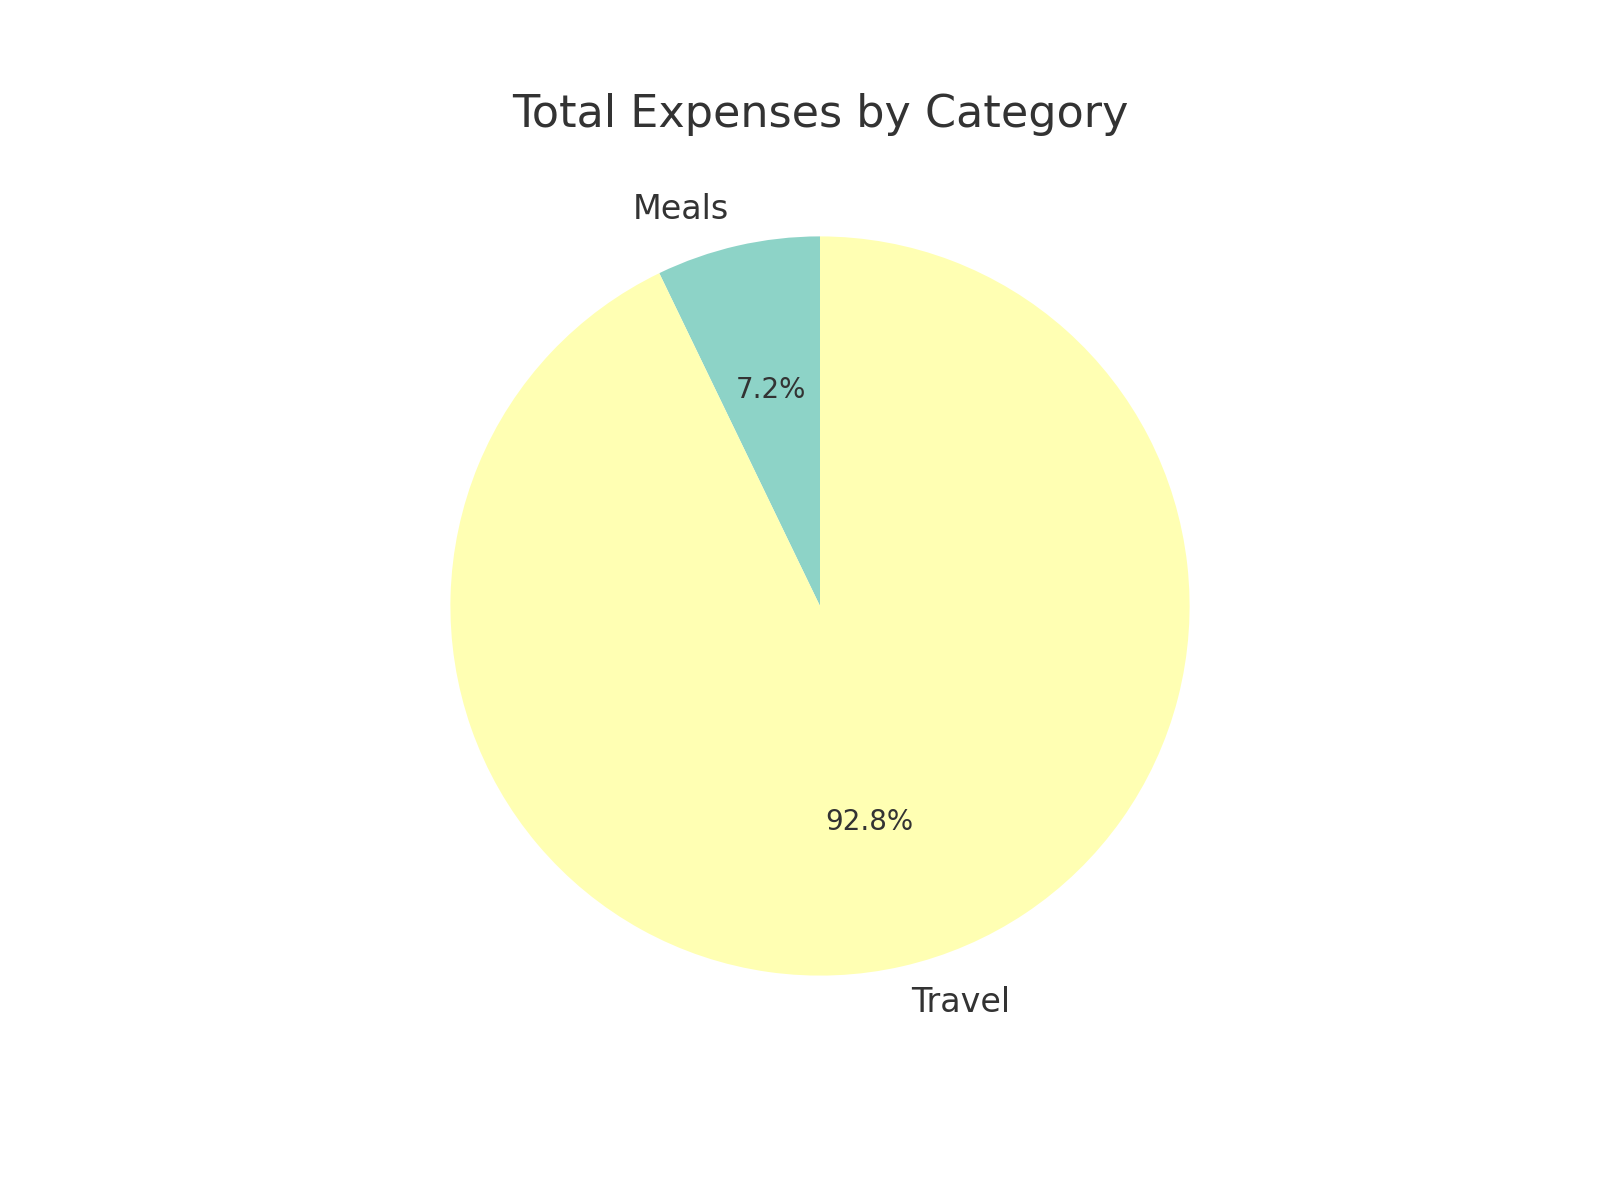


Displaying: expenses_by_merchant.png


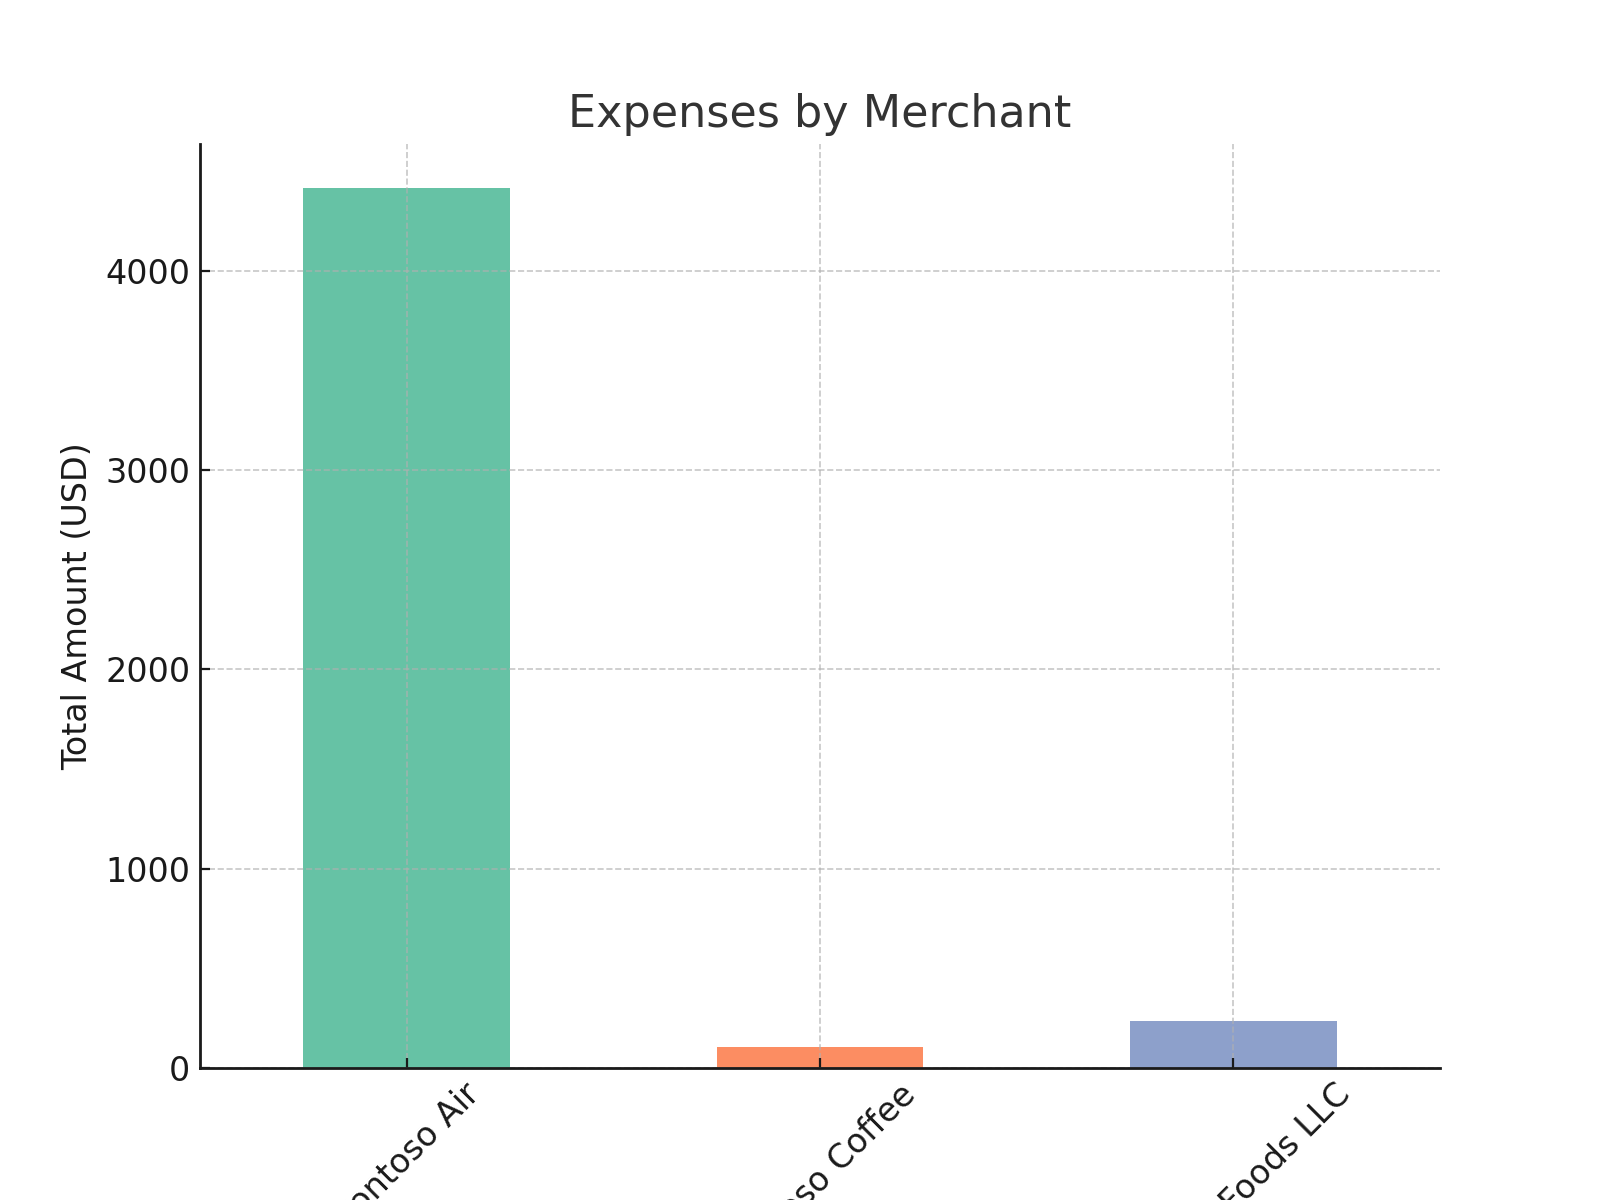


Displaying: distribution_of_expenses.png


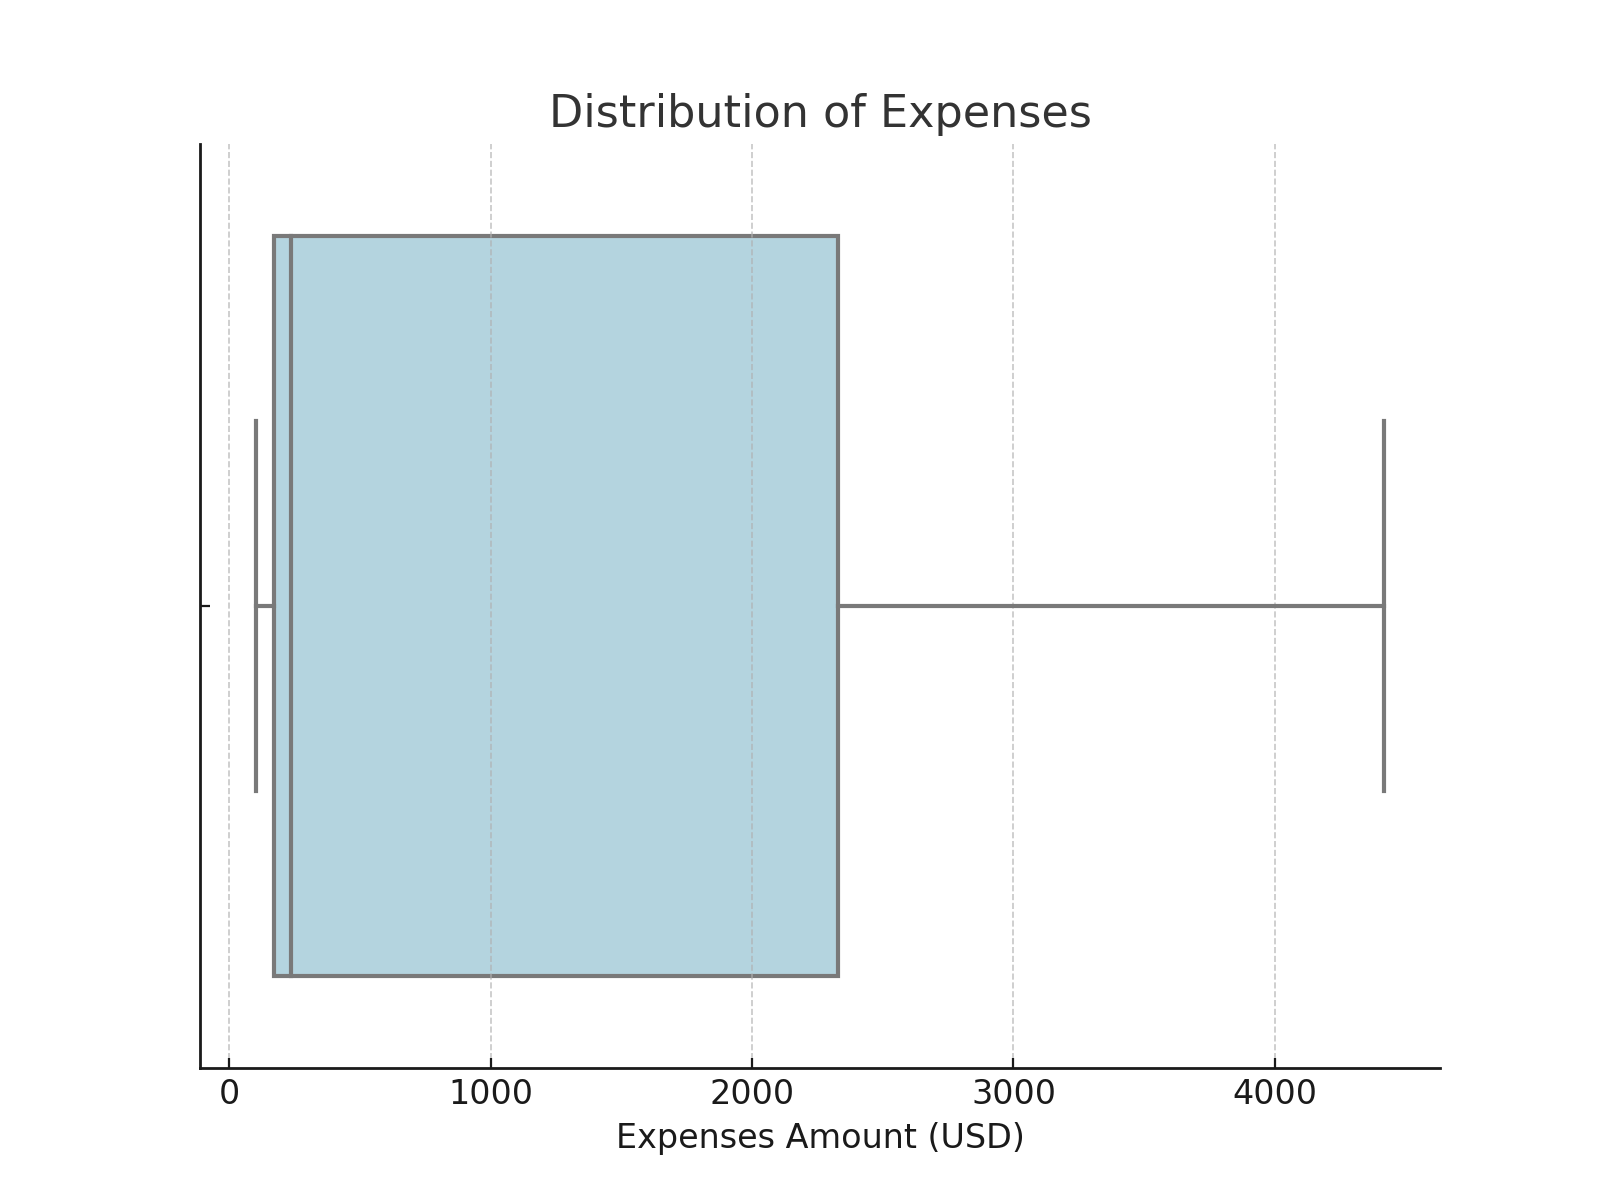

Deleted agent: asst_TMnVkPaupUvUk3y3tJNGsv1g


In [37]:
expense_analysis_results = await analyze_expenses_with_code_interpreter()

## Conclusion

In this notebook, we explored the Azure AI Agents SDK through focused, independent examples that demonstrate its key capabilities:

1. Creating basic agents for conversational interactions
2. Enabling document search through file search tools
3. Returning structured data with JSON schema functions
4. Solving technical problems with code interpreter
5. Combining multiple tools for comprehensive capabilities

Each example is designed to be independently runnable, allowing you to experiment with specific features that interest you. Feel free to modify the examples, combine different techniques, or adapt them to your specific use cases.

The Azure AI Agents SDK provides a powerful platform for building intelligent agents that can access various tools and resources to better assist users with their tasks. 